<a href="https://colab.research.google.com/github/Zod55/pytorch-deep-learning/blob/main/vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!sudo kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
#this note will be for the import of the data
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt


train_data = FashionMNIST(root="data", train=True, download=True, transform=ToTensor(),target_transform=None)
test_data = FashionMNIST(root="data", train=False, download=True, transform=ToTensor(),target_transform=None)


100%|██████████| 26421880/26421880 [00:02<00:00, 12465537.64it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211750.20it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3944942.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11158799.48it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
class_name = train_data.classes

class_name[0]

'T-shirt/top'

In [46]:
#here we will makt the data ready
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_train_data = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              pin_memory=True)


batch_test_data = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False,
                             pin_memory=True)




In [8]:
#the model
class visionMD(nn.Module):
  def __init__(self,in_features,out_features,hidden):
    """ a model that will recognize photos from fsmfation

    Args:
    in_features - the photo in 28x28 tensor,
    out_features - the class the photo is belong to 0-9,
    hidden - the hidden units of the model


    Return:
    the class that the photo is belong to 0-9
    """
    super().__init__()
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(in_features=in_features,out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden,out_features=out_features)
    )
  def forward(self,x):
      return self.model(x)


model0 = visionMD(in_features= 784,
                  out_features= len(train_data.classes),
                  hidden= 64).to(device)


In [9]:
#the training loop optimizer and loss function
torch.manual_seed(42)

#optimizer
optimizer = torch.optim.SGD(model0.parameters(),lr = 0.1)
#loss function nn.CrossEntropyLoss() multi classesfication problem
loss_fn = nn.CrossEntropyLoss()


epochs = 5

for epoch in range(epochs):
  train_loss = 0
  print(f"Epoch: {epoch} ----------------\n")
  for  img, target in batch_train_data:
    img = img.to(device)
    target = target.to(device)
    model0.train()

    img_pred = model0(img)

    loss = loss_fn(img_pred,target)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"train_loss: {train_loss/ len(batch_train_data)}")

  model0.eval()
  test_loss = 0
  with torch.inference_mode():
    for x,y in batch_test_data:
      x=x.to(device)
      y= y.to(device)
      test_pred = model0(x)
      loss = loss_fn(test_pred,y)
      test_loss += loss
    print(f"test loss {test_loss / len(batch_test_data)}")




Epoch: 0 ----------------

train_loss: 0.5694014430046082
test loss 0.4514431059360504
Epoch: 1 ----------------

train_loss: 0.413282185792923
test loss 0.46343758702278137
Epoch: 2 ----------------

train_loss: 0.37720608711242676
test loss 0.4185854196548462
Epoch: 3 ----------------

train_loss: 0.3549421727657318
test loss 0.3947769105434418
Epoch: 4 ----------------

train_loss: 0.33792242407798767
test loss 0.38663166761398315


In [10]:

with torch.inference_mode():
   img , label = test_data[6]
   model_label = model0(img.to(device))
   print(model_label)

tensor([[ 2.6473,  0.2441,  5.7689,  1.6197,  9.5780, -7.4000,  7.3148, -7.8419,
         -1.6466, -8.5525]], device='cuda:0')


In [11]:
def model_eval(model: torch.nn.Module,
               data_loder: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device):
  """Returns a dictionary containing the result of the model predicting data"""
  loss = 0
  with torch.inference_mode():
    for x,y in data_loder:
      x , y = x.to(device), y.to(device)
      y_pred = model(x)
      loss += loss_fn(y_pred,y)
    loss /= len(data_loder)
    return {"model name":model.__class__.__name__,
           "loss": loss.item()}


In [12]:
def train_loop(model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               train_data: torch.utils.data.DataLoader,
               epochs: int,
               optimizer: torch.optim,
               device:torch.device,
               show_loss:bool = False):
  """ Returns the trained model and the learning carv"""
  loss_per_epoch = {}
  for epoch in range(epochs):
   train_loss = 0
   for  x,y in batch_train_data:
     x,y= x.to(device), y.to(device)
     model.train()

     img_pred = model(x)

     loss = loss_fn(img_pred,y)
     train_loss += loss
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
   model0.eval()
   loss_per_epoch[f"epoch number {epoch}"] = (train_loss/len(batch_train_data)).item()
  if show_loss == True:
    print(loss_per_epoch)
  #  loss_per_epoch["model"] = model
  return model

In [13]:
trained_model = train_loop(model0,loss_fn,batch_train_data,100,optimizer,device)


KeyboardInterrupt: 

In [ ]:
# trained_model

In [ ]:
tested_model = model_eval(trained_model,batch_train_data,loss_fn,device)
# model_eval

In [ ]:
# tested_model

In [ ]:
# with torch.inference_mode():
#    img , label = test_data[7342]
#    model_label = trained_model(img.to(device))
#    print(model_label.argmax())
#    model_label

In [ ]:
# img , label = test_data[7342]
# label

In [14]:
from typing import SupportsIndex
class cnnmodel(nn.Module):
   def __init__(self,input:int,output:int,hidden_units:int):
        super().__init__()

        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=input,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.ConvBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classefiar = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features= hidden_units*49,
                                                  out_features= len(train_data.classes)),
                                        )
        # self.model = nn.Sequential()
   def forward(self,x):
     x = self.ConvBlock1(x)
     x = self.ConvBlock2(x)
     x =  self.classefiar(x)
     return x

In [15]:

model2 = cnnmodel(input=1,
                  output=len(train_data.classes),
                  hidden_units=10).to(device)




In [16]:
image, target = train_data[1]
target

0

In [17]:
model2(image.unsqueeze(0).to(device)).argmax()

tensor(3, device='cuda:0')

In [18]:
#loss and optimizer for the cnn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr= 0.1)

In [19]:
# training loop
# print(model2.parameters)
model2 = train_loop(model=model2,
           loss_fn=loss_fn,
           train_data=batch_train_data,
           epochs=10,
           optimizer=optimizer,
           device=device)

# print(trained_model2.parameters)
tested_model2 = model_eval(model=model2,
                           data_loder= batch_test_data,
                           loss_fn=loss_fn,
                           device=device)

In [20]:
#the training loop optimizer and loss function
torch.manual_seed(42)

#optimizer
optimizer = torch.optim.SGD(model2.parameters(),lr = 0.1)
#loss function nn.CrossEntropyLoss() multi classesfication problem
loss_fn = nn.CrossEntropyLoss()

# another options it to manual train the model
epochs = 1

for epoch in range(epochs):
  train_loss = 0
  print(f"Epoch: {epoch} ----------------\n")
  for  img, target in batch_train_data:
    img = img.to(device)
    target = target.to(device)
    model2.train()

    img_pred = model2(img)

    loss = loss_fn(img_pred,target)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"train_loss: {train_loss/ len(batch_train_data)}")

  model2.eval()
  test_loss = 0
  with torch.inference_mode():
    for x,y in batch_test_data:
      x=x.to(device)
      y= y.to(device)
      test_pred = model2(x)
      loss = loss_fn(test_pred,y)
      test_loss += loss
    print(f"test loss {test_loss / len(batch_test_data)}")




Epoch: 0 ----------------

train_loss: 0.22814269363880157
test loss 0.2746293544769287


In [21]:
import pandas as pd
# db = pd.DataFrame([tested_model2,
#                    tested_model])
# db

In [22]:
def make_pred(model:nn.Module,
              data:any,
              device:torch.device = device):
  pred = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = sample.unsqueeze(dim=0).to(device)
      pred_logits =  model(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
      pred.append(pred_prob.cpu())

  return torch.stack(pred)

In [23]:
import random
test_label =[]
test_sample =[]

for sample ,label  in test_data:
    test_sample.append(sample)
    test_label.append(label)



In [24]:
tested_model2

{'model name': 'cnnmodel', 'loss': 0.2707065939903259}

In [25]:
pred = make_pred(model2,test_sample)
pred_label = pred.argmax(dim=1)


In [26]:
len(pred_label)

10000

In [27]:
pred_label[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

Text(0.5, 1.0, 'Ankle boot')

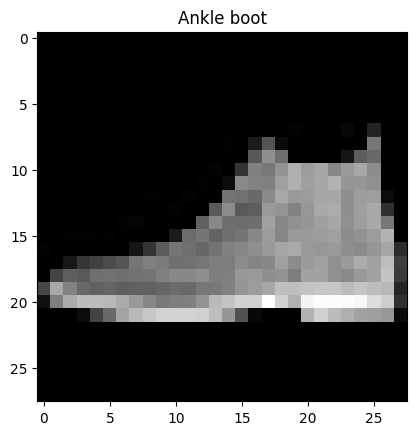

In [28]:

plt.imshow(test_sample[0].squeeze(),cmap = "gray")
plt.title(label=class_name[test_label[0]])

ValueError: num must be an integer with 1 <= num <= 9, not 10

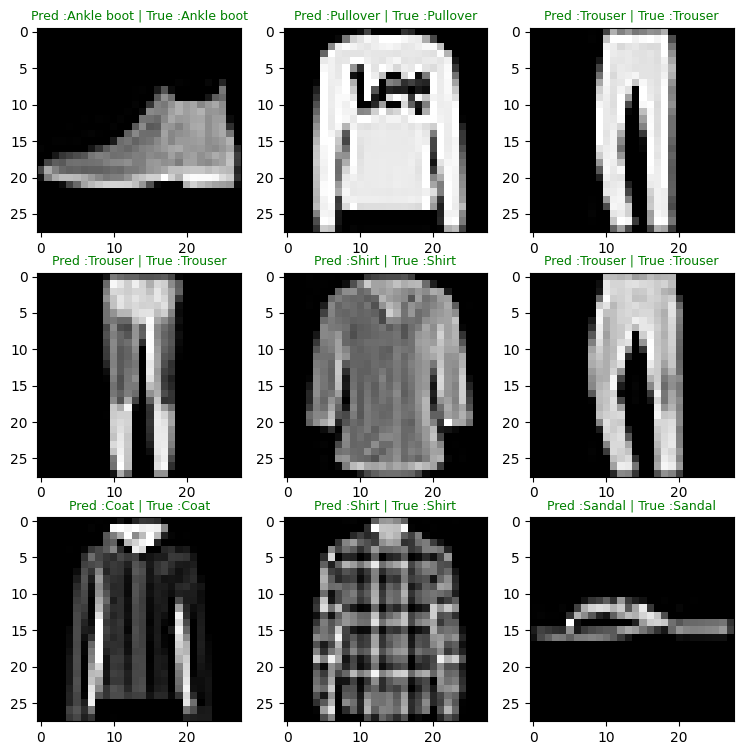

In [29]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_sample):
  #create the plot figure
  plt.subplot(nrows,ncols,i+1)
  #displaying the image
  plt.imshow(sample.squeeze(),cmap="gray")
  #get the predition label for the sample
  pred_lab = class_name[pred_label[i]]
  #get the true label for the sample
  truth_label = class_name[test_label[i]]
  title = f"Pred :{pred_lab} | True :{truth_label}"
  if truth_label == pred_lab:
    plt.title(title,c="g",fontsize=9)
  else:
    plt.title(title,c="r",fontsize=9)





plt.axis()

In [47]:
y_preds = []
from tqdm.auto import tqdm
# torch.manual_seed(0)
model2.eval()
with torch.inference_mode():
   for x,y in tqdm(batch_test_data,desc="prob..."):
    x,y = x.to(device),y.to(device)
    #making logits
    y_logits = model2(x)
    #logits->  prediction probabilitios -> label
    y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_preds = torch.cat(y_preds)
y_preds[:10]

prob...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [31]:
test_data.targets[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [32]:
import mlxtend

!pip install -q torchmetrics -U mlxtend
assert int(mlxtend.__version__.split(".")[1]) > 19 , "need to update  mlxtend"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user


AssertionError: need to update  mlxtend

In [48]:

try:
  import mlxtend , torchmetrics
  assert int(mlxtend.__version__.split(".")[1]) >= 19 , "need to update  mlxtend"
except:
  !pip install -q torchmetrics -U mlxtend
  import mlxtend ,torchmetrics


In [49]:
pred = make_pred(model2,test_sample)
pred_label = pred.argmax(dim=1)


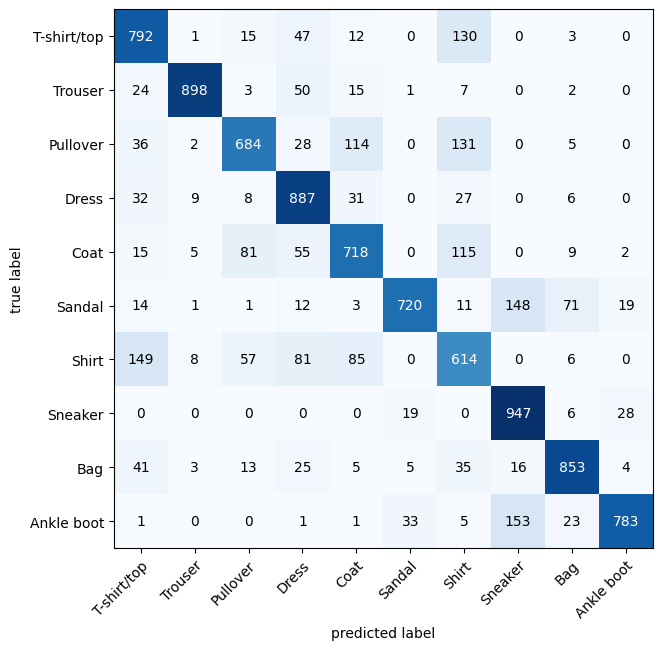

In [50]:

# Note : confusion metrix is a comperesent between the model prediction and he actual  labels
from torchmetrics import  ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#1. setup the confusion metrix and make it to a tensor
confusion_m = ConfusionMatrix(num_classes=len(class_name),task="multiclass")
confusion_tensor = confusion_m(y_preds,
                               target=test_data.targets)

# plot the confusion metrix

fig , ax = plot_confusion_matrix(
    conf_mat=confusion_tensor.numpy(),
    class_names=class_name,
    figsize=(10,7)
    )


